In [7]:
#Imports
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
dim = 100

In [8]:
# get dinos
def getDinos(data, classes, data_type, print_n=False):
    images = []
    labels = []
    path = "dataset/" + data_type + "/"
    for i,f in enumerate(classes):
        p = path + f
        j=0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
            j+=1
    images = np.array(images)
    labels = np.array(labels)
    print("Elementos en images: ", len(images))
    print("Elementos en labels: ", len(labels))
    return images, labels


In [9]:
#Choose your dinos
data = 'dataset/wonders_of_world_images.csv'
dinos = pd.read_csv(data)
classes = dinos.folder_name.unique()
#Get Images and Labels
X_t, y_train = getDinos(dinos, classes, 'training', print_n=True)
X_test, y_test = getDinos(dinos, classes, 'test', print_n=True)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

Elementos en images:  720
Elementos en labels:  720
Elementos en images:  10
Elementos en labels:  10


In [10]:
#plot
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v
def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    print("v = ", v)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = classes[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure(figsize = [16,16])
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = classes[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

v =  [385, 335]


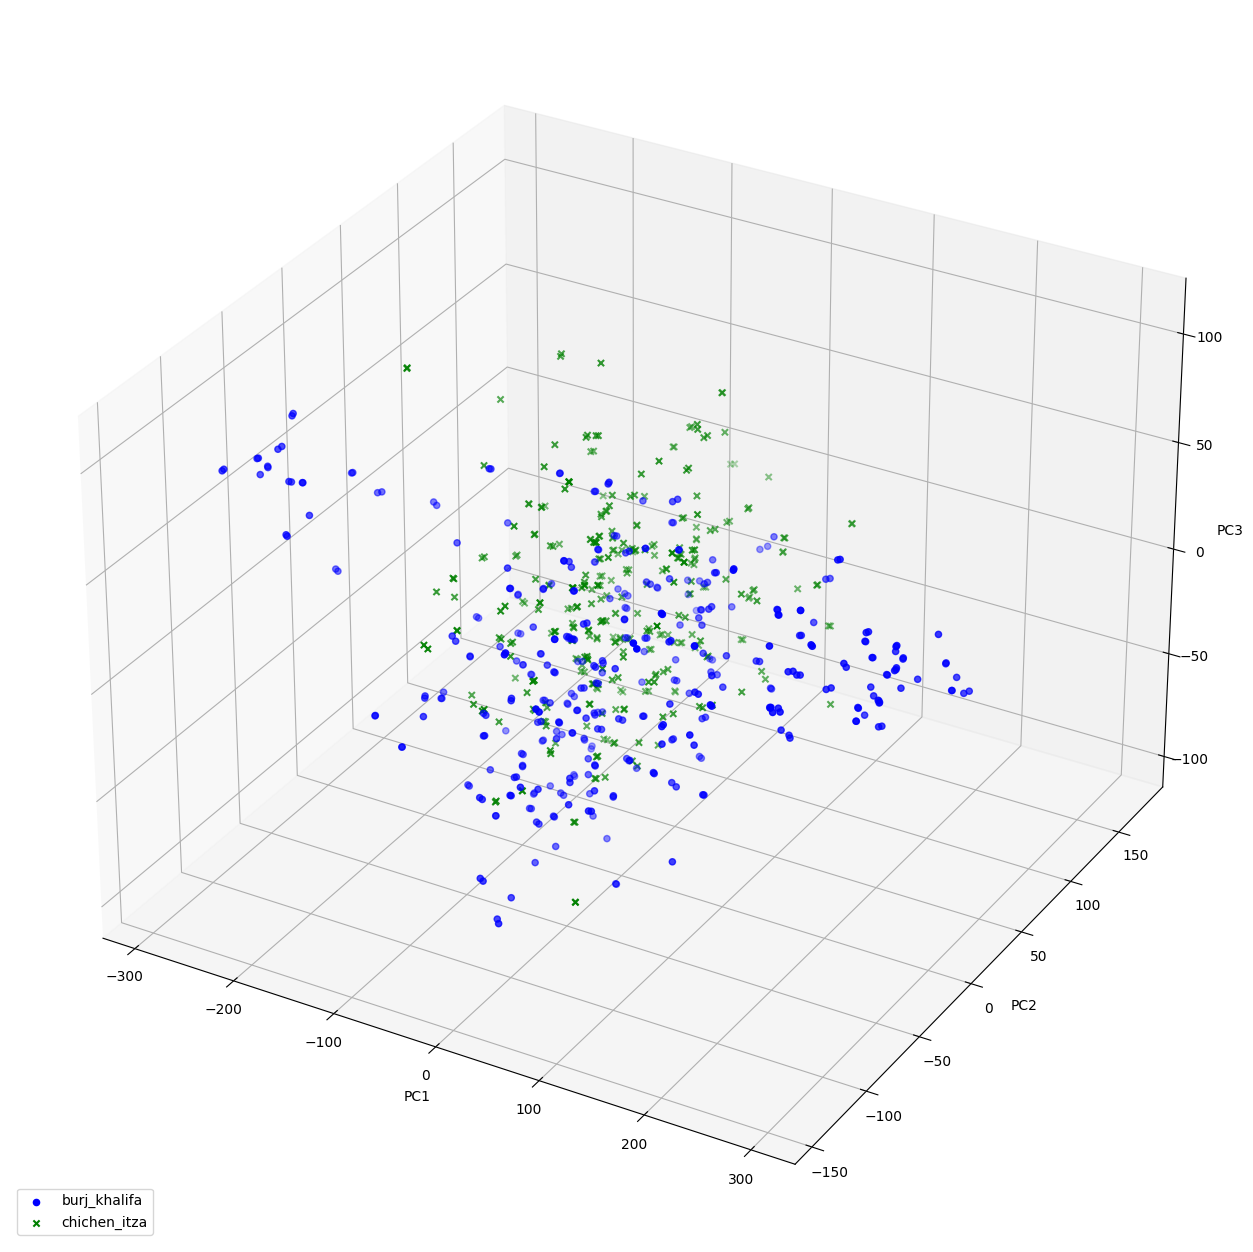

In [11]:
pca = PCA(n_components=3)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 3)

Accuracy with SVM: 90.00%


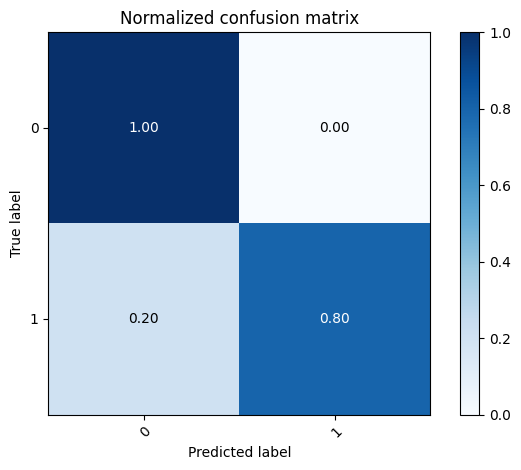

In [12]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred,classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()
# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

Accuracy with K-NN: 70.00%


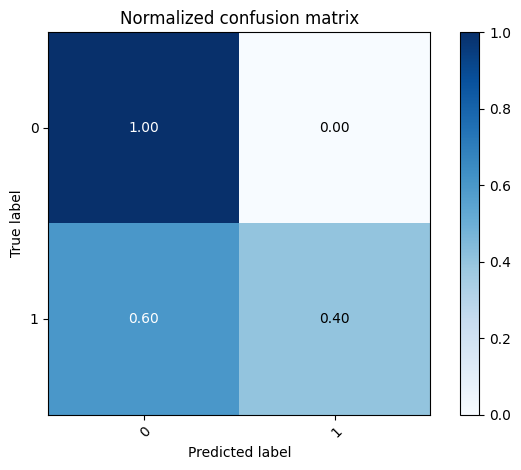

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()
# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)


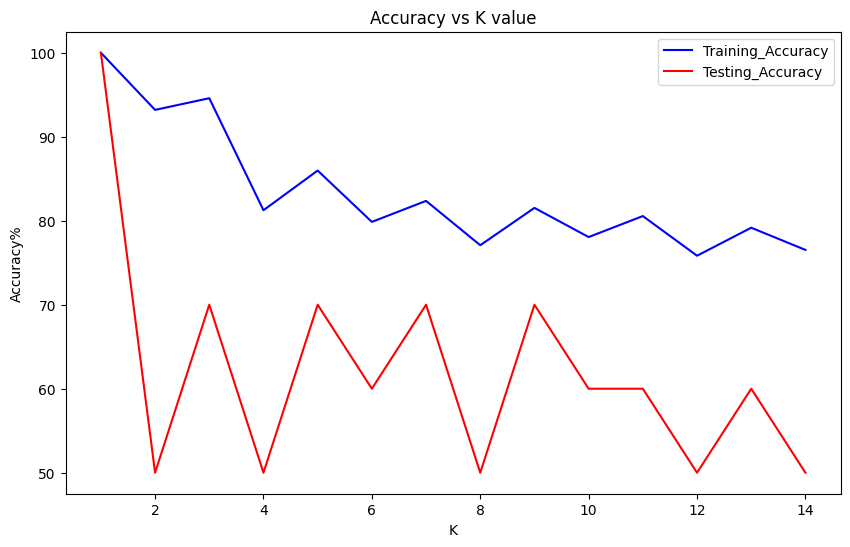

In [16]:
accuracy_train = []
accuracy_test = []
for i in range(1,15): #check all possible values for 1 to 15
    k_nn = KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(X_train,y_train)
    pred_i = k_nn.predict(X_test)
    accuracy_train.append(k_nn.score(X_train,y_train)*100)
    accuracy_test.append(k_nn.score(X_test,y_test)*100)
accuracy_train_array=np.asarray(accuracy_train)
accuracy_test_array=np.asarray(accuracy_test)

plt.figure(figsize=(10,6))
plt.plot(range(1,15),accuracy_train_array, label='Training_Accuracy', color='blue')
plt.plot(range(1,15),accuracy_test_array, label='Testing_Accuracy', color='red')
plt.legend()
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy%')
plt.show()
